# Futures long-only performance summary

This notebook summarises long-only performance statistics for major futures contracts provided by various data sources. Daily returns are computed by rolling the front contract before either the first notice day or the last trade day to avoid deliveries. Concretely, a daily return on a given day is written as follows:

$$
r_{t, i} = \frac{F_{t, i} - F_{t-1, t}}{F_{rolldate, i}}
$$

where $F_{t, i}$ is the futures price at time $t$ for an instrument $i$, $F_{rolldate, i}$ is the futures price when we roll into the contract. All functionalities as well as underlying data are provided by a private library `vivace`.

In [1]:
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest.contract import all_futures_lo_map
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.stats import Performance, PerfStats
from vivace.enums import Strategy

Matplotlib is building the font cache; this may take a moment.


`all_futures_lo_map` contains the list of all available futures contracts for long-only calculation.

In [2]:
all_futures_lo_map

ticker
AC            MSCI World
AD     Australian Dollar
AE                   AEX
AP               SPI 200
B8     CZCE Ferrosilicon
             ...        
YQ       DCE Coking Coal
YY          DCE Iron Ore
Z               FTSE 100
ZB    New Zealand Dollar
ZO                  Oats
Name: name, Length: 168, dtype: object

Without any signals, `BacktestEngine` calculates simple long-only strategies by default. `Performance` computes typical performance metrics such as Sharpe ratio.

In [3]:
results = []

for ticker, name in all_futures_lo_map.items():
    engine = BacktestEngine(
        instrument=ticker,
        strategy=Strategy.DELTA_ONE.value,
        log_level=logging.WARNING,
    )
    engine.run()
    equity_curve = engine.calculate_equity_curve(calculate_net=False)
    stats = Performance(equity_curve).summary().squeeze()
    
    results.append([
        name,
        equity_curve.index[0].strftime('%d-%b-%Y'),
        equity_curve.index[-1].strftime('%d-%b-%Y'),
        stats[PerfStats.CAGR.value],
        stats[PerfStats.ANN_VOL.value],
        stats[PerfStats.SHARPE.value],
        stats[PerfStats.SKEWNESS.value],
    ])
    
result = pd.DataFrame(results, columns=[
    'contract', 'start_end', 'end_date',
    PerfStats.CAGR.value, 
    PerfStats.ANN_VOL.value,
    PerfStats.SHARPE.value,
    PerfStats.SKEWNESS.value,
]).set_index('contract')

In [4]:
result.shape

(168, 6)

# Performance summary

This table displays contract information such as the contract name as well as performance statistics. Bar charts are superimposed for annualised returns and Sharpe ratios based on its value.   Statistics are in contracts' local currencies.
Note that some start dates do not match the exact inception of the futures contract because of limited data availability.

In [5]:
(result
 .style.format({
        PerfStats.CAGR.value: "{:.1%}",
        PerfStats.ANN_VOL.value: "{:.1%}",
        PerfStats.SHARPE.value: "{:.2f}",
        PerfStats.SKEWNESS.value: "{:.2f}",
    })
 .bar(subset=PerfStats.CAGR.value)
 .bar(subset=PerfStats.SHARPE.value))

,start_end,end_date,CAGR,Annualised vol,Sharpe ratio,Skewness
contract,,,,,,
MSCI World,22-Aug-2014,27-Oct-2025,8.1%,16.0%,0.51,-0.53
Australian Dollar,13-Jan-1987,27-Oct-2025,1.9%,11.5%,0.17,-0.49
AEX,23-Aug-2005,27-Oct-2025,6.5%,20.1%,0.32,-0.19
SPI 200,11-Sep-2001,27-Oct-2025,4.7%,16.3%,0.29,-0.51
CZCE Ferrosilicon,24-Jul-2015,27-Oct-2025,0.0%,24.7%,0.00,0.12
CZCE Manganese Silic,29-Sep-2014,27-Oct-2025,7.1%,21.6%,0.33,0.16
Soybean Oil,01-Jul-1959,27-Oct-2025,2.2%,25.2%,0.09,0.13
British Pound,16-May-1972,27-Oct-2025,0.2%,9.8%,0.02,-0.22
Brazilian Real,08-Nov-1995,27-Oct-2025,3.2%,15.6%,0.21,-0.30


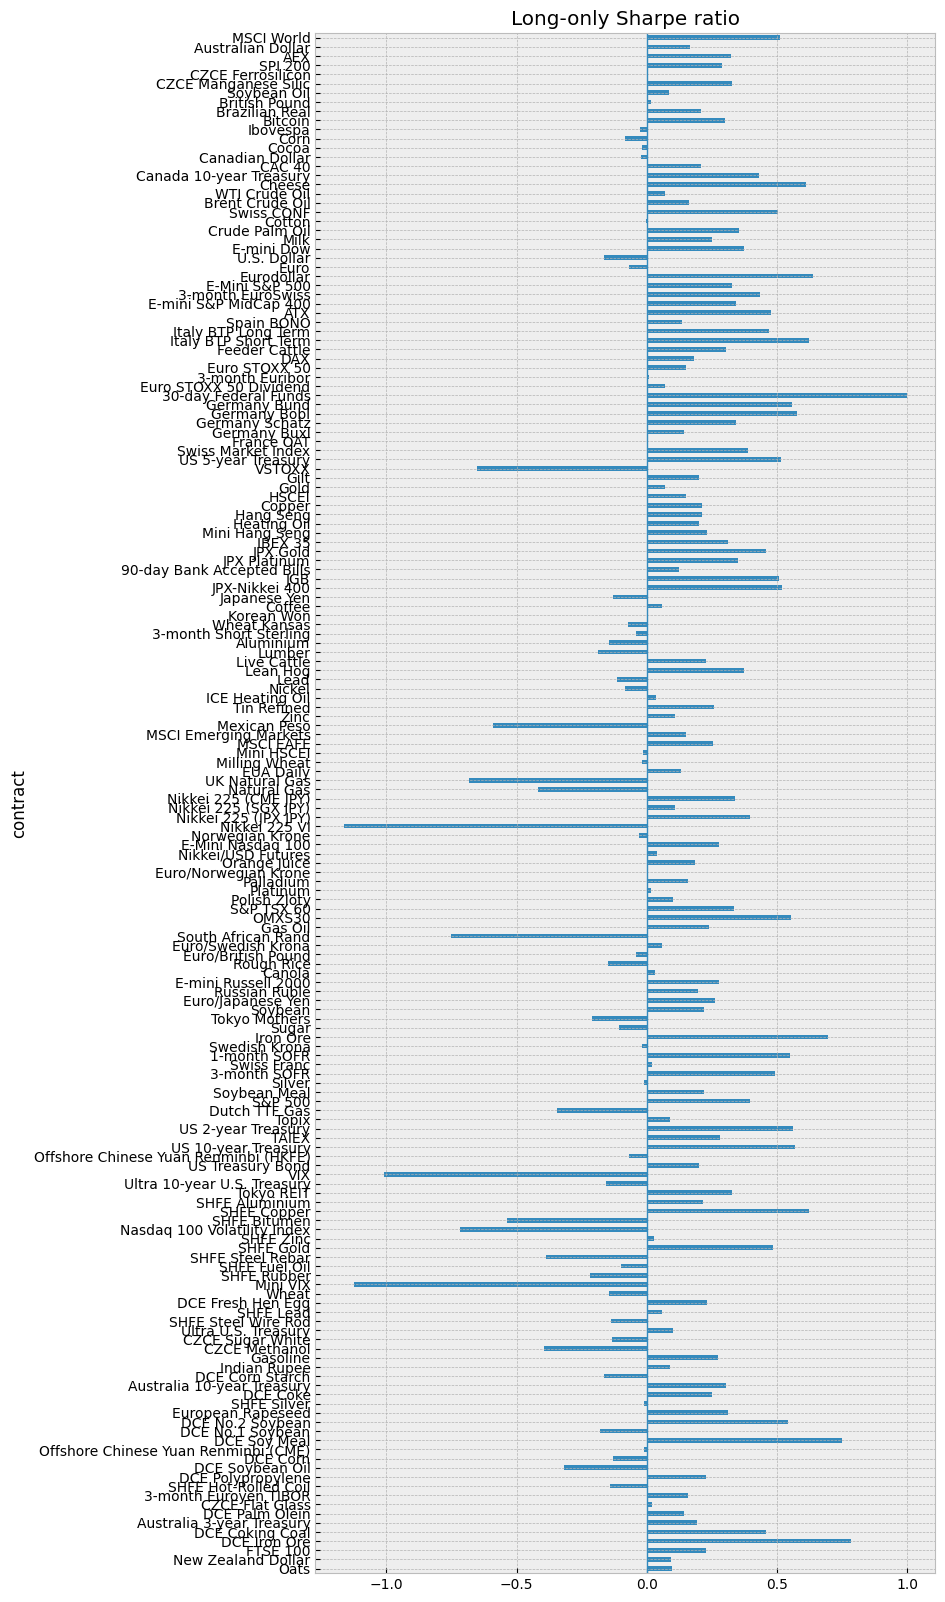

In [6]:
fig, ax = plt.subplots(figsize=(8, 20))
ax.set_title("Long-only Sharpe ratio")
ax.set_ylabel("Sharpe ratio")
result[PerfStats.SHARPE.value].loc[::-1].plot(kind="barh", ax=ax, grid=True);  # reverse the plot order
ax.axvline(0, lw=1);

# Plot cumulative return series

Here only the E-mini S&P 500 futures is shown as an example.

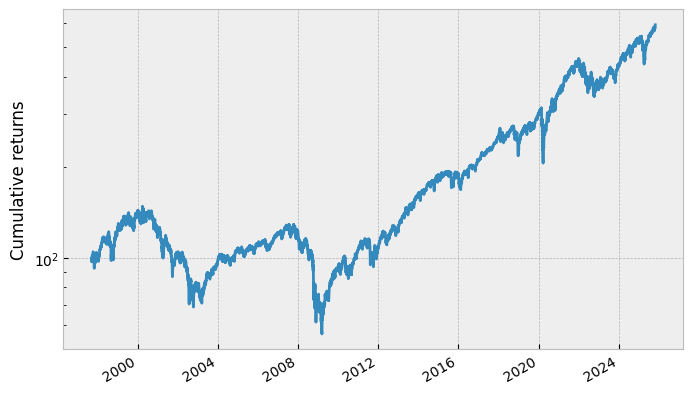

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
engine = BacktestEngine(
    instrument='ES',
    strategy=Strategy.DELTA_ONE.value,
    log_level=logging.WARNING,
)
engine.run()
engine.calculate_equity_curve(calculate_net=False).plot(ax=ax, logy=True)
ax.set_ylabel('Cumulative returns');

In [8]:
print(f'Updated: {datetime.now(pytz.utc).strftime("%d-%b-%Y %H:%M")}')

Updated: 28-Oct-2025 23:14
